## HW4

## Q1: the TD($\lambda$) algorithm (5%)
Consider a larger version of the Random Walk problem. 
Now we have 19 states instead of 5 and the left terminal state gives a reward of -1. 
The starting state is still the centre state. 

**Task**:
- Implement the off-line $\lambda$-return / TD($\lambda$) algorithm:
- Compare the RMS(root mean square) error averaged over the 19 states between the predictions at the end of the episode for the 19
states and their true values, over the first 10 episodes, and over 10 runs (10 different sequence of walks). In other words, for each run, you generate 10 episodes and use TD($\lambda$) to learn the value. Then you calculate the difference between the learned value and the true value (you may want to use the Bellman equation to obtain the true value), square the difference, average it over 10 runs and take the square root. 

- Plot the averaged RMS error vs $\alpha$ values for the following $\lambda$-values:

parameter settings: 
```
lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = [np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 0.55, 0.05),
          np.arange(0, 0.22, 0.02),
          np.arange(0, 0.11, 0.01)]
```

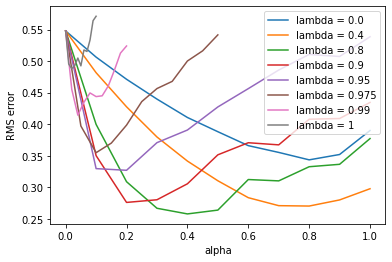

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class HelperFunc:
    def __init__(self, rate, step_size):
        self.rate = rate
        self.step_size = step_size
        self.weights = np.zeros(N_STATES + 2)

    def value(self, state):
        return self.weights[state]

    def learn(self, state, reward):
        pass

    def new_episode(self):
        pass

class TDLambda(HelperFunc):
    def __init__(self, rate, step_size):
        super().__init__(rate, step_size)
        self.rate_truncate = 1e-3

    def new_episode(self):
        self.trajectory = [START_STATE]
        self.reward = 0.0

    def learn(self, state, reward):
        self.trajectory.append(state)

        if state in END_STATES:
            self.reward = reward
            self.T = len(self.trajectory) - 1
            self.off_line_learn()

    def n_step_return_from_time(self, n, time):
        end_time = min(time + n, self.T)
        returns = self.value(self.trajectory[end_time])
        if end_time == self.T:
            returns += self.reward
        return returns

    def lambda_return_from_time(self, time):
        returns = 0.0
        lambda_power = 1
        for n in range(1, self.T - time):
            returns += lambda_power * self.n_step_return_from_time(n, time)
            lambda_power *= self.rate
            if lambda_power < self.rate_truncate:
                break
        returns *= 1 - self.rate
        if lambda_power >= self.rate_truncate:
            returns += lambda_power * self.reward
        return returns

    def off_line_learn(self):
        for time in range(self.T):
            state = self.trajectory[time]
            delta = self.lambda_return_from_time(time) - self.value(state)
            delta *= self.step_size
            self.weights[state] += delta

def random_walk(helper_func):
    helper_func.new_episode()
    current_state = START_STATE
    while current_state not in END_STATES:
        new_state = current_state + np.random.choice([-1, 1])
        if new_state == 0:
            reward = -1
        elif new_state == N_STATES + 1:
            reward = 1
        else:
            reward = 0
        helper_func.learn(new_state, reward)
        current_state = new_state

# constants
N_STATES = 19
states = np.arange(1, N_STATES + 1)

START_STATE = 10
END_STATES = [0, N_STATES + 1]

real_state_values = np.arange(-20, 22, 2) / 20.0
real_state_values[0] = real_state_values[N_STATES + 1] = 0.0

runs = 56
lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = [np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 0.55, 0.05),
          np.arange(0, 0.22, 0.02),
          np.arange(0, 0.11, 0.01)]

episodes = 10
errors = [np.zeros(len(alphas_)) for alphas_ in alphas]


for run in range(runs):
  for lambda_index, rate in enumerate(lambdas):
    for alpha_index, alpha in enumerate(alphas[lambda_index]):
      value_function = TDLambda(rate, alpha)
      for episode in range(episodes):
        random_walk(value_function)
        state_values = [value_function.value(state) for state in states]
        errors[lambda_index][alpha_index] += np.sqrt(np.mean(np.power(state_values - real_state_values[1: -1], 2)))

for error in errors:
  error /= episodes * runs

for i, lambd in enumerate(lambdas):
  plt.plot(alphas[i], errors[i], label=f"lambda = {lambd}")
plt.xlabel("alpha")
plt.ylabel("RMS error")
plt.legend()
plt.show()

## Q2: Implement the double Q-learning algorithm on the Cliff Walking example (5%)

#### Task:
- Set the number of episodes to 1000
- Output the estimated optimal policy
- Plot the average reward during episodes (see the plot in Seminar 4)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Estimated optimal policy:
DDLLUDDDDDDL
DLDDDDDDDDLL
DDDDDDDDDDDL
SUUUUUUUUUUU


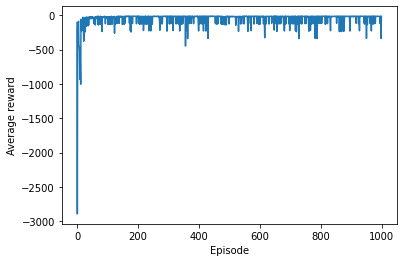

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

# Initialize the environment
env = gym.make('CliffWalking-v0')

# Define the state, action, and reward spaces
num_states = env.observation_space.n
num_actions = env.action_space.n
reward_space = np.zeros((num_states, num_actions))
for state in range(num_states):
    for action in range(num_actions):
        for next_state, reward, done, info in env.P[state][action]:
            reward_space[state, action] += reward

# Initialize the Q tables
Q1 = np.zeros((num_states, num_actions))
Q2 = np.zeros((num_states, num_actions))

# Set the hyperparameters
alpha = 0.5
gamma = 1.0
epsilon = 0.1
num_episodes = 1000

# Define the epsilon-greedy policy
def epsilon_greedy(Q1, Q2, state, epsilon):
    if np.random.uniform() < epsilon:
        action = np.random.randint(num_actions)
    else:
        Q = (Q1 + Q2) / 2.0
        action = np.argmax(Q[state])
    return action

# Define the update rule
def update(Q1, Q2, state, action, reward, next_state, alpha, gamma):
    if np.random.uniform() < 0.5:
        Q1[state, action] += alpha * (reward + gamma * np.max(Q2[next_state]) - Q1[state, action])
    else:
        Q2[state, action] += alpha * (reward + gamma * np.max(Q1[next_state]) - Q2[state, action])
    return Q1, Q2

# Initialize the variables for tracking the rewards and steps
rewards = np.zeros(num_episodes)
steps = np.zeros(num_episodes)

# Loop over the episodes
for episode in range(num_episodes):
    # Reset the environment to the starting state
    state = env.reset()
    done = False
    t = 0
    # Loop over the steps in the episode
    while not done:
        # Select an action according to an epsilon-greedy policy based on the average of the two Q tables
        action = epsilon_greedy(Q1, Q2, state, epsilon)
        # Take a step
        next_state, reward, done, info = env.step(action)
        # Update the selected Q table with the observed reward and next state, and update the average Q table accordingly
        Q1, Q2 = update(Q1, Q2, state, action, reward, next_state, alpha, gamma)
        # Update the variables for tracking the rewards and steps
        rewards[episode] += reward
        steps[episode] += 1
        # Update the state and time step
        state = next_state
        t += 1

# Output the estimated optimal policy based on the average of the two Q tables
Q = (Q1 + Q2) / 2.0
policy = np.argmax(Q, axis=1)
policy_str = ""
for state in range(num_states):
    if state == env.reset(): # starting state
        policy_str += "S"
    elif reward_space[state, :].max() == 0: # cliff state
        policy_str += "X"
    elif reward_space[state, :].max() < 0: # off-cliff state
        policy_str += "-"
    elif policy[state] == 0:
        policy_str += "U"
    elif policy[state] == 1:
        policy_str += "D"
    elif policy[state] == 2:
        policy_str += "L"
    elif policy[state] == 3:
        policy_str += "R"


print("Estimated optimal policy:")
print(policy_str[:12])
print(policy_str[12:24])
print(policy_str[24:36])
print(policy_str[36:48])

#Plot the average reward during episodes
plt.plot(np.arange(num_episodes), rewards)
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.show()